In [17]:
%matplotlib inline
import nengo
import numpy as np
import matplotlib.pyplot as plt
from dv import LegacyAedatFile

Here is an implementation of a simple actor-critic Reinforcement Learning algorithm in Nengo.

This document is based on ideas I sketched out when teaching learning rules in Nengo 5 years ago (https://github.com/tcstewar/syde556-1/blob/master/SYDE%20556%20Lecture%2010%20Learning.ipynb) and I'd implemented all of these pieces before, but this is the first time I've combined them all together into a full actor-critic RL system.  This means that I haven't done any parameter tuning and there's probably lots of room for improvement.  

In addition to the link above, I'm also indebted to these documents for (hopefully) keeping me on the right track for these algorithms.  Please let me know where I've got things wrong and correct me!
 - https://towardsdatascience.com/introduction-to-actor-critic-7642bdb2b3d2
 - https://towardsdatascience.com/understanding-actor-critic-methods-931b97b6df3f
 - http://incompleteideas.net/book/first/ebook/node66.html
 
The basic idea behind an actor-critic algorithm is that you are making two different predictions.  One thing you are predicting is the future value of the current state (i.e. the expected rewards you will be getting in the future, given that you are in the current state).  This is the Critic.  The other thing you are predicting is how good the different available actions are given the current state.  This is the Actor.

## Implementing the Critic

The Critic part is pretty much the standard reinforcement learning idea.  The idea is that we have a neural network outputing this prediction, and we can update that prediction based on the reward we expect and the reward we get.  The standard trick is:

- $V(s_t) = r_t + \gamma r_{t+1} + \gamma^2 r_{t+2} + ...$
- $V(s_t) = r_t + \gamma V(s_{t+1})$

So, if we have a network outputting $V(s_t)$, and then we see what state we get to and what reward we actually get, then we can use that to update the neural network.

- $\delta_t = r_t + \gamma V(s_{t+1}) - V(s_t)$

(Note: there's lots of variants of this, most noteably ones that use $Q(s,a)$ instead of $V(s)$, which learns the expected reward of doing action $a$ in state $s$)

Of course, that equation about future events, so let's shift the time by one time step so that it's about current and past events.

- $\delta_{t-1} = r_{t-1} + \gamma V(s_{t}) - V(s_{t-1})$

To implement this in Nengo, all we need is some neurons that store the state, and we compute the error signal as above and apply it to the learning rule.  For this, we're just using the PES learning rule (which in this case is just standard delta rule, so we are only updating the readout/decoder weights and no backprop is needed).  

Since the computation involves shifting things in time, we also need to figure out how to implement that delay, and to decide how long it is in actual time (should it be one time-step? But in a continuous neuron model like LIF, what does a time step really mean?).  One way to do this would be to add a delay on the `nengo.Connection` (we do this via the `synapse` parameter).  Another option is to use a low-pass filter as the synapse, and using a longer time-constant to give something like a longer delay.  This also should work well with spiking neurons, as it spreads the spike out over time a bit.  (Note: it's interesting to compare this low-pass filter to the idea of eligibility traces...).

Let's try just implementing the Critic part of the algorithm.  We need a simple situation to be in with some state and rewards.  So let's have a system that is just constantly going around in a circle and gives a reward at one point in the circle.  

In [38]:
class Environment:
    def __init__(self):
        self.events = self.load_gesture('./DVS_Gesture_Dataset/DvsGesture/user01_fluorescent.aedat')
        self.cursor = 0

    def update(self):
        if self.cursor < len(self.events):
            state = self.events[self.cursor]
            self.cursor += 1
        else:
            load_gesture("new_gesture")
        reward = 0
        return *state, reward
    
    def load_gesture(self, name):
        list_events = []
        events = []
        with LegacyAedatFile(name) as f:
            for i, event in enumerate(f):
                events.append(event)
                if i % 100 == 0:
                    list_events.append(events)
        return list_events
                
environment = Environment()

First, let's set up the basic structure that we can add the learning to.  

In [46]:
tau_slow = 0.01
tau_fast = None
discount = 0.95

environment = Environment()
model = nengo.Network()
with model:
    
    # create the environment
    #   it has 101 inputs: the first 100 are the state, and the last is the reward
    env = nengo.Node(lambda t: environment.update(), size_out=101)
    
    # set up some other Nodes that just grab the state and reward information,
    #  just for clarity
    state = nengo.Node(None, size_in=100)
    nengo.Connection(env[:-1], state, synapse=None)
    reward = nengo.Node(None, size_in=1)
    nengo.Connection(env[-1], reward, synapse=None)
    
    # create the neural network to encode the state.  The default is LIF neurons.
    ens = nengo.Ensemble(n_neurons=10000, dimensions=100)
    nengo.Connection(state, ens, synapse=None)
    
    # this is the output value that we critic will learn
    value = nengo.Node(None, size_in=1)

    # record the value and the reward
    p_value = nengo.Probe(value)
    p_reward = nengo.Probe(reward)

Now we need the learning system.  First, we need to compute the error signal, which is $r_{t-1} + \gamma V(s_{t}) - V(s_{t-1})$.  But, to do the time delays, we are using the synapses, so it's more like $h(t)\circledast r(t) + \gamma V(t) - h(t)\circledast V(t)$ (where $h(t)$ is the synapse model). This is just adding a bunch of things together that we already have, and sometimes filtering them, so here's how we compute that just by using `nengo.Connection` objects.:

In [6]:
with model:
    value_error = nengo.Node(None, size_in=1)
    nengo.Connection(value, value_error, transform=-discount, synapse=tau_fast)
    nengo.Connection(value, value_error, synapse=tau_slow)
    nengo.Connection(reward, value_error, transform=-1, synapse=tau_slow)

Now we need to create the connection this error signal will be applied to.  This is just the standard PES rule, which is usually pretty much just delta rule.  However, in this case we have to be a little more careful because this is the error signal for the *past* ($\delta_{t-1}$).  Normal delta rule would just be $\Delta w_i = -\alpha \delta a_i$ (where $\alpha$ is the learning rate, $\delta$ is the error signal, and $a_i$ is the output of the $i$th neuron).  But, PES also has a synaptic filter that can be applied to the neuron activity: $\Delta w_i = -\alpha \delta (h(t) \circledast a_i)$.  So, in the ideal case, if we had a delay as $h(t)$, then that would be exactly the standard RL learning rule.  We can do a delay here, or we can do the same trick of doing a low-pass filter instead to get something like a delay that might work well with spiking neurons.  We specify this for the PES rule with the `pre_synapse` parameter.

In [7]:
with model:
    # make the connection to learn on
    c = nengo.Connection(ens.neurons, value, transform=np.zeros((1, ens.n_neurons)), 
                         learning_rule_type=nengo.PES(learning_rate=1e-4, pre_synapse=tau_slow))
    # connect the error signal to the learning rule
    nengo.Connection(value_error, c.learning_rule, synapse=None)

Now we can run the model and see what it does.

In [8]:
sim = nengo.Simulator(model)
sim.run(100)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

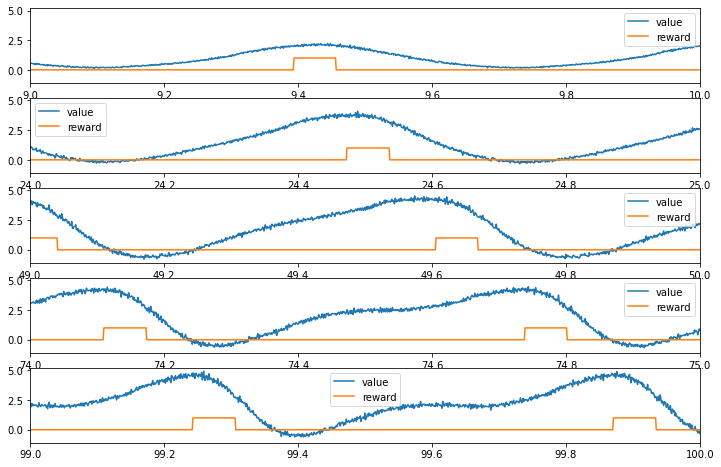

In [9]:
plt.figure(figsize=(12,8))
for i,t in enumerate([10, 25, 50, 75, 100]):
    plt.subplot(5, 1, i+1)
    plt.plot(sim.trange(), sim.data[p_value], label='value')
    plt.plot(sim.trange(), sim.data[p_reward], label='reward')
    plt.xlim(t-1,t)
    plt.legend()

That seems to work!  The anticipated value starts climbing just before the reward, and then drops once the reward appears. You can see a bit of the learning trajectory there where at the beginning (first row), it just knows that there's a reward somewhere around that sate, and then as it gets more experience (lower rows) it becomes pretty good about anticipating the reward, and then at learning that after the reward it isn't going to get another reward any time soon.

There's lots that can be explored about this.  In addition to the number of neurons, the learning rate, and the `tau_slow` and `tau_fast` parameters, there is also things like setting `neuron_type=nengo.RectifiedLinear()` or `neuron_type=nengo.Sigmoid()` when creating the `nengo.Ensemble` would use non-spiking neurons.  You can also try an actual delay rather than a low-pass filter by making use of the following `Delay` object and setting `tau_slow = Delay(0.01)`.  One other interesting thing to try is adjusting the sparsity in the neural network by setting `intercepts=nengo.dists.Uniform(0.6,1)` when creating the `nengo.Ensemble`.  

In [10]:
# an implementation of a pure Delay synapse for nengo
class Delay(nengo.synapses.Synapse):
    def __init__(self, delay, size_in=1):
        self.delay = delay
        super().__init__(default_size_in=size_in, default_size_out=size_in)

    def make_state(self, shape_in, shape_out, dt, dtype=None, y0=None):
        return {}

    def make_step(self, shape_in, shape_out, dt, rng, state=None):
        steps = int(self.delay/dt)
        if steps == 0:
            def step_delay(t, x):
                return x
            return step_delay
        assert steps > 0

        state = np.zeros((steps, shape_in[0]))
        state_index = np.array([0])

        def step_delay(t, x, state=state, state_index=state_index):
            result = state[state_index]
            state[state_index] = x
            state_index[:] = (state_index + 1) % state.shape[0]
            return result

        return step_delay

## Implementing the Actor

So now the system can figure out how good a particular state is (in terms of what sorts of future rewards are expected).  So how can we figure out what the right action to take would be that would lead to good states?

The fun trick in Actor-Critic learning is that it turns out you can use *the same error signal* as you're computing for the Critic part to tell you what action to take!  The basic intuition is that if you do an action and it turns out better than you expected (i.e. $\delta_{t-1} = r_{t-1} + \gamma V(s_{t}) - V(s_{t-1})$ is positive), then this means whatever action you just performed is better than you thought it was, and so you should increase your chance of doing that action in the state you were in ($s_{t-1}$).

So, all we need is to set up another `Connection` to readout how good our different actions are (one numerical value per action).  We then pass those values through a softmax to turn them into probabilities, and sample from that probability distribution to get our actual choice.  (Note: we could do all these steps using neurons in nengo, but for simplicity let's just do those steps as normal code).

Now when we compute the error for that `Connection`, we do

$\delta_{actor, i} = \delta$ if $i$ is the chosen action, otherwise $0$ 

(i.e. if you chose action $i$ and it was better than you thought it was ($\delta > 0$) then increase your chance of doing that action in the state $\delta_{actor, i}>0$)

That's the simplest form of the idea, but there's a bunch of variations.  In particular, if choose action $i$ and it's better than I expect, then not only should I increase how good I think that action is, but I should also decrease how good I think the other actions are (and vice-versa).  Furthermore, I might want to scale this based on the probability of choosing those actions.  To make this a little less ad-hoc, one common thing to do is to say something like "the loss function is $-ln(p_{chosen})\delta$.  If you go and take the derivative of that loss function with respect to the actor output weights (i.e. taking the derivative through that softmax that's happening0, you see that this is the same as the following error rule:

$\delta_{actor, i} = \delta(1-p_i)$ if $i$ is the chosen action, otherwise $-\delta p_i$ 

(Note: This is known as the advantage actor-critic algorithm)

Let's add this to the nengo model.  We'll have to slightly modify the `Environment` so that it actually accepts an action choice (rather than constantly spinning one way).  We'll have two actions: move left and move right.  

In [11]:
class Environment:
    def __init__(self):
        self.theta = 0
        
    def update(self, x):
        if x[0] > 0:
            self.theta += 0.01
        if x[1] > 0:
            self.theta -= 0.01
        reward = 1 if np.cos(self.theta)>0.95 else 0
        return np.sin(self.theta), np.cos(self.theta), reward

And now let's re-create the Critic part of the model as well as the new Actor part.

In [12]:
tau_slow = 0.01
tau_fast = None
discount = 0.95

environment = Environment()
model = nengo.Network()
with model:
    
    # create the environment
    #   it has 3 outputs: the first 2 are the state, and the last is the reward
    env = nengo.Node(lambda t, x: environment.update(x), size_in=2, size_out=3)
    
    # set up some other Nodes that just grab the state and reward information,
    #  just for clarity
    state = nengo.Node(None, size_in=2)
    nengo.Connection(env[:2], state, synapse=None)
    reward = nengo.Node(None, size_in=1)
    nengo.Connection(env[2], reward, synapse=None)
    
    # create the neural network to encode the state.  The default is LIF neurons.
    ens = nengo.Ensemble(n_neurons=200, dimensions=2)
    nengo.Connection(state, ens, synapse=None)
    
    # this is the output value that we critic will learn
    value = nengo.Node(None, size_in=1)

    # record the value and the reward
    p_value = nengo.Probe(value)
    p_reward = nengo.Probe(reward)
    
    # compute the critic error
    value_error = nengo.Node(None, size_in=1)
    nengo.Connection(value, value_error, transform=-discount, synapse=tau_fast)
    nengo.Connection(value, value_error, synapse=tau_slow)
    nengo.Connection(reward, value_error, transform=-1, synapse=tau_slow)
    
    # make the connection to learn on
    c = nengo.Connection(ens.neurons, value, transform=np.zeros((1, ens.n_neurons)), 
                         learning_rule_type=nengo.PES(learning_rate=1e-4, pre_synapse=tau_slow))
    # connect the error signal to the learning rule
    nengo.Connection(value_error, c.learning_rule, synapse=None)

    ### HERE IS THE NEW STUFF FOR THE ACTOR
    
    # the raw output from the network
    raw_actions = nengo.Node(None, size_in=2, label='raw_actions')
    
    # compute the softmax
    def softmax(t, x):
        return np.exp(x)/np.sum(np.exp(x))
    actions = nengo.Node(softmax, size_in=2, label='actions')
    nengo.Connection(raw_actions, actions, synapse=None)

    # do the random sampling and output which action we're taking
    #  (here I just decided to represent choosing the action as +1 and not choosing as -1)
    def choice_func(t, x):
        c = np.random.choice(np.arange(2), p=x)
        result = [-1, -1]
        result[c] = 1
        return result
    choice = nengo.Node(choice_func, size_in=2, size_out=2, label='choice')
    nengo.Connection(actions, choice, synapse=None)
    
    # and now connect the choice to the environment
    nengo.Connection(choice, env, synapse=None)
    
    # and here is the computation of the error signal
    c_actor = nengo.Connection(ens.neurons, raw_actions, transform=np.zeros((2, ens.n_neurons)), 
                               learning_rule_type=nengo.PES(learning_rate=1e-4, pre_synapse=tau_slow))

    # implement the advantage actor-critic error rule
    #  the Node gets 5 inputs: the delta for the critic part, 2 values indicating which action was chosen
    #  (+1 for the chosen and -1 for the non-chosen ones), and the choice probabilities for the 2 actions
    def actor_error_func(t, x):
        delta = x[0]
        chosen = x[1:3]
        prob = x[3:5]
        # compute the error
        e = np.where(chosen>0, delta*(1-prob), -delta*prob)
        return e

    actor_error = nengo.Node(actor_error_func, size_in=5, label='actor_error')
    nengo.Connection(value_error, actor_error[0], synapse=None)
    nengo.Connection(choice, actor_error[1:3], synapse=None)
    nengo.Connection(actions, actor_error[3:5], synapse=None)
    nengo.Connection(actor_error, c_actor.learning_rule, transform=-1, synapse=tau_slow) 
    
    p_choice = nengo.Probe(choice)   # record the actual choices
    p_prob = nengo.Probe(actions)    # record the probabilities 

Now let's run the model and see what happens.

In [13]:
sim = nengo.Simulator(model)
sim.run(100)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

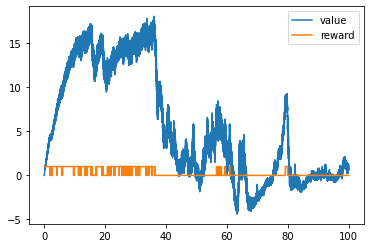

In [15]:
plt.plot(sim.trange(), sim.data[p_value], label='value')
plt.plot(sim.trange(), sim.data[p_reward], label='reward')
plt.legend()
plt.show()

Well, it seems to be anticipating the reward okay, but it doesn't seem to be learning to perform actions that help it get that reward.  Let's let it keep learning for longer.  (Note: calling `sim.run` again continues the simulation from where was.)

In [16]:
sim.run(500)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

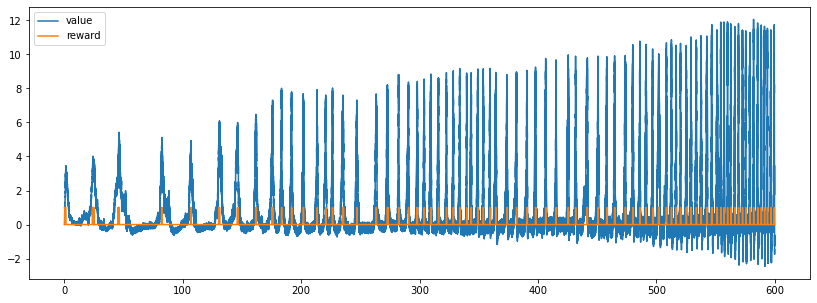

In [141]:
plt.figure(figsize=(14,5))
plt.plot(sim.trange(), sim.data[p_value], label='value')
plt.plot(sim.trange(), sim.data[p_reward], label='reward')
plt.legend()
plt.show()

That looks like learning to me!

## Things to explore

While this shows the general approach works, there are many things to explore to see how they affect the model.

First, there's all the parameters that we mentioned when just looking at the Critic part:
 - number of neurons
 - neuron type (spiking, ReLU, sigmoid, etc.)
 - `tau_fast`, `tau_slow`, `discount`
 - `learning_rate` (for both actor and critic)
 - various versions of actor-critic (i.e. the error computation for the actor learning)
 
Second, there's the application to different tasks.  The two next things to try would be the standard cart-pole and mountain car RL test cases.  However, this is a bit tricky because you have to decide how to reset the run and make sure that it's not learning between runs.  I prefer tasks that are always continuing, like this one.  Indeed, I might even be tempted to jump straight up to the Atari Pong example, since that can be more about a very long continuous run.

For these more complex tasks, we would want to add some recurrence to the network.  The easiest way to do that would be to add a recurrent connection on the `nengo.Ensemble` that implements the LMU.  That way it's already a good recurrent network for storing information over time, and we don't have to do any learning in the recurrence.  We could also do a standard reservoir by having a random recurrent connection.  It would also be interesting to try implementing e-prop or another learning algorithm, if we can get those working.

I mentioned the representation sparsity earlier, and I also think that will be an important parameter to work with, especially given that this sort of online learning exhibits a lot less catestrophic forgetting given a sparser neural representation.  There are a variety of ways of imposing sparsity in Nengo, but the easiest is what I mentioned above with adjusting the intercepts.  This seems to affect the Critic part of the algorithm a lot, but I haven't explored it in the Actor.